### 1. Analisys of the edges completeness in the collaboration graph

In [2]:
import networkx as nx
from node2vec import Node2Vec
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from pecanpy import node2vec
from gensim.models import Word2Vec

In [ ]:
!gdown https://drive.google.com/file/d/15VA3ambTZWSyUp-rTs9H28KbBRiFgO9M/view?usp=sharing

In this part we'll load the training data and create a random subgraph from the collaboration graph so that the density of the h-index is preserved. This data we'll be used in subsequent sections to test the speed of some algorithms like node2vec.

In [8]:
# Load the list of authors in the training (for testing)
f_train = open("../Data/train.csv","r")
list_lines = f_train.readlines()
dict_h_index = {}

for line in list_lines[1:]:
    line = line.replace("\n","").split(",",1)
    dict_h_index[int(line[0])] = float(line[1])
    
num_nodes_subgraph = 100000
nodes_subgraph = random.sample(dict_h_index.keys(),num_nodes_subgraph)
h_index_subgraph = [dict_h_index[author_id] for author_id in nodes_subgraph]

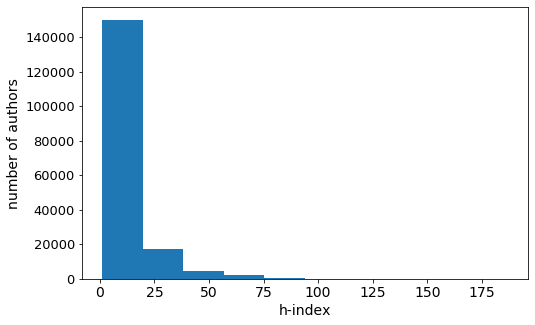

In [18]:
plt.figure(figsize=(8,5))
plt.hist(dict_h_index.values())
plt.xlabel("h-index",fontsize=14)
plt.ylabel("number of authors",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.savefig("histogram_hindex_authors")

In [3]:
# Load the precomputed weighted graph
g_w = nx.read_edgelist('../Data/graph.weighted.edgelist', nodetype=int, data=True)

In [24]:
print('Some of the edges of the graph:\n')
count = 0
for (u,v,d) in g_w.edges(data=True):
    if(count > 10):
        break
    print("({0},{1},{2}) = ".format(u,v,d))
    count += 1

Some of the edges of the graph:

(2002218453,1999212242,{'coauthorship': 0}) = 
(2002218453,2032640503,{'coauthorship': 0}) = 
(2002218453,2475931411,{'coauthorship': 0}) = 
(2002218453,2477743428,{'coauthorship': 0}) = 
(2002218453,2504846374,{'coauthorship': 0}) = 
(2002218453,2597456557,{'coauthorship': 1}) = 
(2002218453,2598017501,{'coauthorship': 0}) = 
(2002218453,2134271654,{'coauthorship': 0}) = 
(2002218453,2138551865,{'coauthorship': 0}) = 
(2002218453,2145694960,{'coauthorship': 0}) = 
(2002218453,2196000661,{'coauthorship': 0}) = 


In [25]:
# Generate a subgraph for testing
sg_w = g_w.subgraph(nodes_subgraph)

In [36]:
n_nodes = sg_w.number_of_nodes()
n_edges = sg_w.number_of_edges()

print('Number of nodes:', n_nodes)
print('Number of edges:', n_edges)

print('\nSome of the edges of the subgraph:\n')
count = 0
for (u,v,d) in sg_w.edges(data=True):
    if(count > 10):
        break
    print("({0},{1},{2}) = ".format(u,v,d))
    count += 1

Number of nodes: 100000
Number of edges: 559991

Some of the edges of the subgraph:

(1268514819,2312076978,{'coauthorship': 1}) = 
(1268514819,1943680126,{'coauthorship': 1}) = 
(2231369732,2055603077,{'coauthorship': 0}) = 
(2294022149,2302951906,{'coauthorship': 1}) = 
(1955856388,2130441415,{'coauthorship': 0}) = 
(1955856388,2142426598,{'coauthorship': 1}) = 
(1955856388,2029951803,{'coauthorship': 1}) = 
(1955856388,2290069899,{'coauthorship': 0}) = 
(1955856388,1930259037,{'coauthorship': 1}) = 
(41943048,2294870485,{'coauthorship': 0}) = 
(2199912458,2281495830,{'coauthorship': 0}) = 


(array([8.5922e+04, 9.8850e+03, 2.6740e+03, 1.1450e+03, 2.4600e+02,
        8.3000e+01, 3.4000e+01, 5.0000e+00, 3.0000e+00, 3.0000e+00]),
 array([  1. ,  19.6,  38.2,  56.8,  75.4,  94. , 112.6, 131.2, 149.8,
        168.4, 187. ]),
 <a list of 10 Patch objects>)

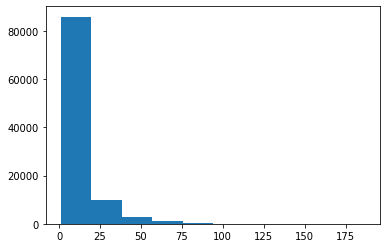

In [33]:
plt.hist(h_index_subgraph)

### 2. [Node2vec model implementation with networkx](https://github.com/eliorc/node2vec)

This sections contains a failed implementation since it takes too long to execute. Go to the section 4 for a dynamic implementation that calculates the probabilities on fly and uses a better data structure for the dense graph.

In [ ]:
# Precompute probabilities and generate walks
node2vec = Node2Vec(g_w, dimensions=32, walk_length=16, num_walks=100, workers=4)

In [ ]:
model = node2vec.fit(window=12, min_count=1)

In [ ]:
model.wv.most_similar(str(nodes_subgraph[0]))

In [ ]:
nodes_subgraph_str = [str(author_id) for author_id in nodes_subgraph]
embeddings = np.array([model.wv[author_id] for author_id in nodes_subgraph_str])

### 3. Dimensionality reduction and visualization for the subgraph

In [ ]:
node_embedding_sg = pd.DataFrame()
node_embedding_sg["author_id"] = nodes_subgraph
node_embedding_sg["embedding_20"] = embeddings
node_embedding_sg.to_csv("../Data/node_embedding_sg.csv",index=False)

In [ ]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [ ]:
# Assign colors to groups
list_groups = [float(x) for x in range(25,-1,-5)]
group_colors = {
    '>=25.0': 'gainsboro',
    '>=20.0': 'lightblue',
    '>=15.0': 'b',
    '>=10.0': 'r',
    '>=5.0': 'teal',
    '>=0.0': 'deepskyblue',
}

colors = []

for author_id in nodes_subgraph:
    for value in list_groups:
        if(dict_h_index[author_id] >= value):
            colors.append(group_colors[">="+str(float(value))])
            break

In [ ]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax.legend(handles=group_patches);

In [ ]:
pca = PCA(n_components=5)
embeddings_pca = pca.fit_transform(embeddings)

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

In [ ]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colors)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax.legend(handles=group_patches);

### 4. [Node2vec model implementation with Pecanpy](https://github.com/krishnanlab/PecanPy)

The version 2 of the weighted graph is obtained by manually replacing the dictionaries with the weights by only the weight values. This was done using Node++.

In [5]:
f = open("graph.weighted.edgelist_v2")

count = 0
for line in f:
    try:
        a,b,c = line.split(" ",2)
    except:
        a = line.split(" ",2)
        #print(",{0},{1},{2},".format(a,b,c))
        print(a)
    count += 1

In [6]:
# load graph object using SparseOTF mode
sg_p = node2vec.SparseOTF(p=1, q=1, workers=4, verbose=False)
sg_p.read_edg("graph.weighted.edgelist_v2", weighted=True, directed=False, delimiter=" ")

# generate random walks
walks = sg_p.simulate_walks(num_walks=100, walk_length=16, n_ckpts=10, pb_len=25)

C:\Users\leder\anaconda3\envs\learning2\lib\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11100. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
# use random walks to train embeddings
w2v_model = Word2Vec(walks, vector_size=32, window=3, min_count=0, sg=1, workers=1, epochs=1)

In [8]:
#w2v_model.save("node_embedding_word2vec_v2.model")
w2v_model.wv.save("../Data/node_embedding_word2vec_v2.wordvectors")

In [1]:
from gensim.models import KeyedVectors

node_embedding_wv = KeyedVectors.load("../Data/node_embedding_word2vec_v2.wordvectors", mmap="r")

In [6]:
nodes_subgraph = set()

f = open('graph.weighted.edgelist_v2','r')

for line in f:
    node_1,node_2,weight = line.split(" ",2)
    nodes_subgraph.add(node_1)
    nodes_subgraph.add(node_1)

In [86]:
print(len(nodes_subgraph))

148533


### 5. Dimensionality reduction and visualization for the whole graph

In [5]:
nodes_graph = list(g_w.nodes())
list_embeddings = []

authors_null_vectors = []

for author_id in nodes_graph:
    try:
        list_embeddings.append(node_embedding_wv[str(author_id)])
    except:
        list_embeddings.append(None)
        authors_null_vectors.append(author_id)

print("Number of null embeddings:{0} out of {1}.".format(len(authors_null_vectors),len(nodes_graph)))
print("Null embeddings:\n",authors_null_vectors)

Number of null embeddings:0 out of 217801.
Null embeddings:
 []


In [6]:
list_embeddings[0]

array([ 0.5115827 ,  0.05221384, -0.9083426 ,  2.5456145 ,  0.44165826,
       -0.5974593 , -0.22110868,  0.33225426, -0.19333388,  0.8425106 ,
        0.8961145 , -0.3640311 , -0.57999176,  0.4848334 , -0.44419903,
        0.8480644 , -0.3294834 ,  0.35033014, -0.5030156 ,  0.5287931 ,
        0.6068285 , -0.55748296,  0.77135795, -0.7194575 ,  0.18928804,
       -0.079108  , -0.68726283,  0.99673444, -1.2074286 ,  1.1795259 ,
        0.7740194 ,  0.54688793], dtype=float32)

In [ ]:
embeddings_train = [node_embedding_wv[str(x)] for x in dict_h_index]
print('Prepared embeddings for training data.\n\nNode embedding associated to the author id 240029540:')
node_embedding_wv['240029540']

In [35]:
dim_node_embeddings = 32
cols_embeddings = ["n_embedding_"+str(i) for i in range(dim_node_embeddings)]
df_node_embeddings = pd.DataFrame()
df_node_embeddings['author_id'] = nodes_graph
df_node_embeddings[cols_embeddings] = np.array(list_embeddings)
df_node_embeddings.to_csv('node_embeddings_32.csv',sep=',', index=False)

In [34]:
df_node_embeddings[:2]

,author_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19
0,2002218453,-0.694879,-0.505028,-2.230974,-0.062975,-0.519640,1.716221,0.016707,1.826956,-0.083150,...,0.932311,-0.772390,-0.944022,-0.863003,0.941812,0.441415,0.572092,1.762829,0.776401,0.619664
1,1999212242,1.454966,-1.988098,-0.526755,-1.633711,0.882088,0.184876,-1.120647,1.363868,0.125685,...,-0.348550,-2.156825,-1.795696,-1.823066,-0.465326,-0.947870,0.650343,0.715935,0.435175,0.173713


#### Dimensionality reduction using TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=7, perplexity=25)
embeddings_2d = tsne.fit_transform(embeddings_train)

In [ ]:
embeddings_2d_df = pd.DataFrame()
embeddings_2d_df['author_id'] = dict_h_index.keys()
embeddings_2d_df['embeddings'] = list(embeddings_2d)

embeddings_2d_df.to_csv("node_embeddings_tsne_2d_p25",index=False)

In [112]:
# Assign colors to groups
list_groups = [float(x) for x in range(25,-1,-5)]
group_colors = {
    '>=25.0': 'gainsboro',
    '>=20.0': 'lightblue',
    '>=15.0': 'b',
    '>=10.0': 'r',
    '>=5.0': 'teal',
    '>=0.0': 'deepskyblue',
}

colors = []

nodes_train = list(dict_h_index.keys())
nodes_subgraph_train = [x for x in nodes_subgraph if int(x) in nodes_train]

for author_id in nodes_train:
    for value in list_groups:
        if(dict_h_index[int(author_id)] >= value):
            colors.append(group_colors[">="+str(float(value))])
            break
        

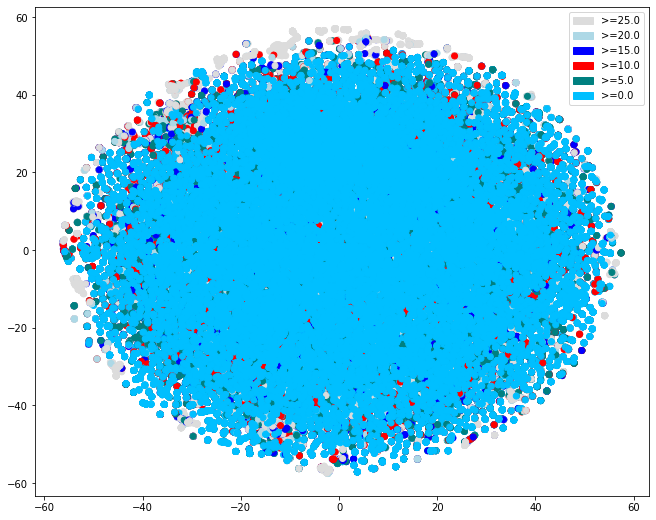

In [114]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax.legend(handles=group_patches)

Let's see the graph without the authors in the *>=0.0* category (label deepskyblue in the previous plot).

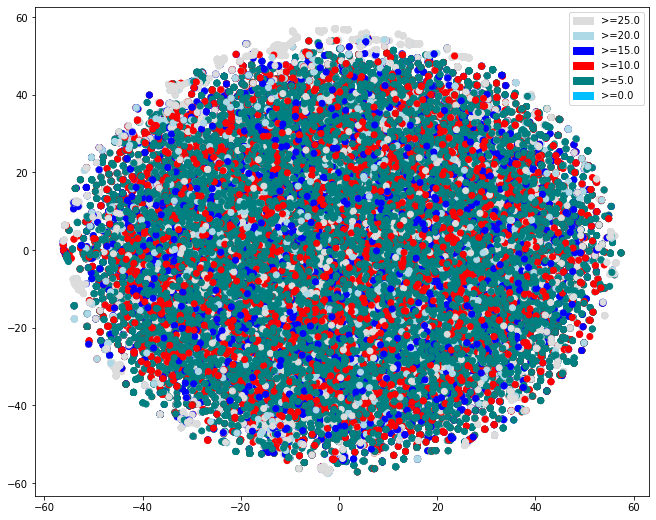

In [128]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

author_id_ge5 = np.array([embeddings_2d[i] for i in range(len(embeddings_2d)) if colors[i] != 'deepskyblue'])
colors_ge5 = [colors[i] for i in range(len(embeddings_2d)) if colors[i] != 'deepskyblue']
ax.scatter(author_id_ge5[:, 0], author_id_ge5[:, 1], c=colors_ge5)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax.legend(handles=group_patches)

#### Dimensionality reduction using PCA

First, let's analyze the singular values and the explained variance ratios. This will help us to decide the output dimension.

In [129]:
pca = PCA(n_components=20)
embeddings_pca = pca.fit_transform(embeddings_train)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.06214365 0.056071   0.05269793 0.05122005 0.05020876 0.04970585
 0.04955379 0.04930604 0.04910569 0.04892368 0.04890142 0.0486838
 0.0485148  0.04835547 0.04823007 0.04804429 0.04773243 0.0476375
 0.04751809 0.04744568]
[413.01354583 392.31513544 380.33185798 374.96085077 371.24078623
 369.37684488 368.81141387 367.88831826 367.14009642 366.45908191
 366.37568548 365.55955746 364.92450952 364.32480701 363.85209929
 363.15062927 361.97009494 361.60995655 361.15649371 360.88120953]


We see that the variance is almost uniformly distributed, so we cannot do dimensionality reduction correctly using PCA. However, we will do this for display purposes only. 

In [118]:
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_train)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.06072308 0.05447615]
[408.26562674 386.69550139]


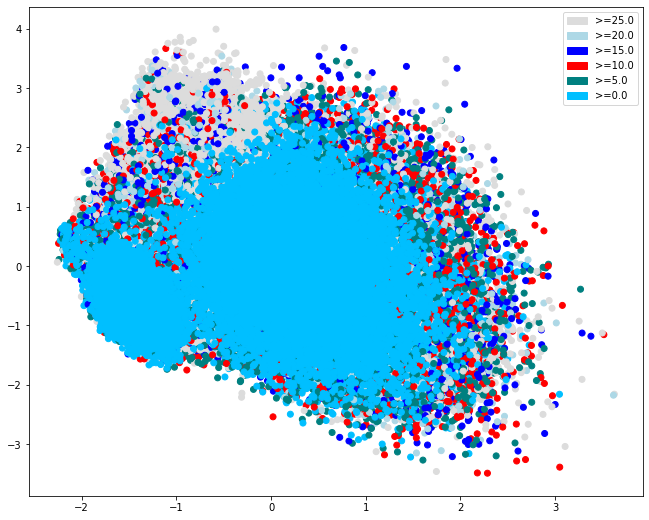

In [119]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=colors)

# Create team patches for legend
group_patches = [mpatches.Patch(color=color, label=group) for group, color in group_colors.items()]
ax.legend(handles=group_patches)